In [17]:
using ITensors
using ITensorMPS
using Plots
using LaTeXStrings

In [15]:
import Pkg; Pkg.add("LaTeXStrings")

    Updating registry at `C:\Users\felip\.julia\registries\General.toml`
   Resolving package versions...
   Installed LERC_jll ────────────────────── v4.0.0+0
   Installed OrdinaryDiffEqRosenbrock ────── v1.3.1
   Installed GR_jll ──────────────────────── v0.73.8+0
   Installed Libmount_jll ────────────────── v2.40.2+0
   Installed LoggingExtras ───────────────── v1.1.0
   Installed Unitful ─────────────────────── v1.21.1
   Installed SciMLJacobianOperators ──────── v0.1.1
   Installed BoundaryValueDiffEqFIRK ─────── v1.0.2
   Installed OpenEXR ─────────────────────── v0.3.3
   Installed PlotUtils ───────────────────── v1.4.3
   Installed NearestNeighbors ────────────── v0.4.21
   Installed TiffImages ──────────────────── v0.10.2
   Installed BoundaryValueDiffEqMIRK ─────── v1.0.1
   Installed RecursiveArrayTools ─────────── v3.27.4
   Installed FileIO ──────────────────────── v1.16.6
   Installed Xorg_libpthread_stubs_jll ───── v0.1.1+1
   Installed OrdinaryDiffEqCore ──────────── v1

Let's start with Exact Diagonalization

In [3]:
# Matrix representations for local operators and states:

X = [0 1; 1 0]
Y = [0 -1im; 1im 0]
Z = [1 0; 0 -1]
Identity = [1 0; 0 1]; #or Using LinearAlgebra and Matrix{Float64}(I, 2, 2)

zero = [1; 0] #↑ = [1; 0]
one = [0; 1] #↓ = [0; 1]

#Note: These functions build all the operators multiplying ⊗ at the right. The basis and everything should follow this convention.

function Enlarge_Matrix_site_j(N, j, matrix)
    # I⊗...⊗I⊗M⊗I...⊗I

    Identity = zeros(size(matrix)) #In case that Identity have not been defined globally before.
    for i=1:size(matrix)[1]; Identity[i,i] = 1; end  
    
    M = Identity
    j == 1 ? M = matrix : nothing
    
    for i=2:N 
        i == j ? M = kron(M, matrix) :  M = kron(M, Identity)        
    end

    return M
end

function Enlarge_Matrix_i_Matrix_j(N, i, j, matrix_i, matrix_j)
    # I⊗...⊗I⊗M_i⊗I...⊗I⊗M_j⊗I⊗I...⊗I

    Identity = zeros(size(matrix_i)) #In case that Identity have not been defined globally before.
    for i=1:size(matrix_i)[1]; Identity[i,i] = 1; end 

    M = Identity

    j == 1 ? M = matrix_j : nothing
    i == 1 ? M = matrix_i : nothing
 
    for k=2:N 
        if k == j
            M = kron(M, matrix_j)
        elseif k == i
            M = kron(M, matrix_i)
        else
            M = kron(M, Identity)        
        end
    end

    return M
end

Enlarge_Matrix_i_Matrix_j (generic function with 1 method)

In [109]:
N = 10
J = 1.0
α = 1.0

function Build_H_Exact(N, J, α)

    H = zeros(2^(N), 2^(N))

    for j=1:N
        for i =1:j-1
            H += J*exp(-α*abs(i-j))*(Enlarge_Matrix_i_Matrix_j(N,i,j,X,X) + Enlarge_Matrix_i_Matrix_j(N,i,j,Y,Y))
            # @show (j, i)
        end
    end
    
    return H
end

function Build_H_MPO(sites, J, α)

    N = length(sites)

    os = OpSum()

    for j=1:N
        for i =1:j-1
            os += J*exp(-α*abs(i-j)), "X", i, "X", j
            os += J*exp(-α*abs(i-j)), "Y", i, "Y", j
            # @show (j, i)
        end
    end

    H = MPO(os, sites);   
    return H
end

Build_H_MPO (generic function with 1 method)

In [110]:
H_ED = Build_H_Exact(N, J, α);

In [111]:
eigvals, eigvecs = eigen(H_ED)
@show eigvals[1]

eigvals[1] = -3.862229651875292


-3.862229651875292

In [112]:
sites = siteinds("Qubit", N)

@show op("X", sites[1])
@show op("Y", sites[1])

H_MPO = Build_H_MPO(sites, J, α);

op("X", sites[1]) = ITensor ord=2
Dim 1: (dim=2|id=493|"Qubit,Site,n=1")'
Dim 2: (dim=2|id=493|"Qubit,Site,n=1")
NDTensors.Dense{Float64, Vector{Float64}}
 2×2
 0.0  1.0
 1.0  0.0
op("Y", sites[1]) = ITensor ord=2
Dim 1: (dim=2|id=493|"Qubit,Site,n=1")'
Dim 2: (dim=2|id=493|"Qubit,Site,n=1")
NDTensors.Dense{ComplexF64, Vector{ComplexF64}}
 2×2
 0.0 + 0.0im  -0.0 - 1.0im
 0.0 + 1.0im   0.0 + 0.0im


In [113]:
Ψ0 = random_mps(sites)
E, Ψ = dmrg(H_MPO,Ψ0; nsweeps = 100, maxdim = 40, cutoff = 10e-10);

After sweep 1 energy=-3.6799099968944327  maxlinkdim=4 maxerr=8.05E-16 time=0.007
After sweep 2 energy=-3.8621870836195487  maxlinkdim=16 maxerr=5.63E-10 time=0.008
After sweep 3 energy=-3.8622296503593097  maxlinkdim=16 maxerr=6.97E-10 time=0.013
After sweep 4 energy=-3.8622296507821985  maxlinkdim=16 maxerr=2.63E-10 time=0.013
After sweep 5 energy=-3.862229650782196  maxlinkdim=16 maxerr=2.61E-10 time=0.014
After sweep 6 energy=-3.8622296507822043  maxlinkdim=16 maxerr=2.61E-10 time=0.013
After sweep 7 energy=-3.8622296507822043  maxlinkdim=16 maxerr=2.61E-10 time=0.013
After sweep 8 energy=-3.862229650782207  maxlinkdim=16 maxerr=2.61E-10 time=0.013
After sweep 9 energy=-3.8622296507822065  maxlinkdim=16 maxerr=2.61E-10 time=0.020
After sweep 10 energy=-3.8622296507822056  maxlinkdim=16 maxerr=2.61E-10 time=0.012
After sweep 11 energy=-3.8622296507822047  maxlinkdim=16 maxerr=2.61E-10 time=0.012
After sweep 12 energy=-3.8622296507822114  maxlinkdim=16 maxerr=2.61E-10 time=0.011
Afte

We got the same ground state, then the MPO is well defined and agrees with the exact diagonalization results. Now we can start thinking about time evolution.

- **Exact Time Evolution**

- **Time dependent variational principle (TDVP)**

- **Time Evolving Block Decimation (TEBD)**

- **Article method with $W_{I}$ MPO**

In [114]:
function Time_Evolution_Op_Exact(t, H)
    #|Ψ(t)> = exp(-itH)|Ψ(0)>
    return U = exp(-1im*t*H)   
end

Time_Evolution_Op_Exact (generic function with 1 method)

Clearly we need some observable to benchmark the time evolution.

In [115]:
function CorrelationsXiXj_FromCenter_Exact(N, Ψ)

    Distance_ij = []
    Correlations = []
    
    Center = round(N/2)
    i = Center 
    j = Center
        
    for k = 1:N-1
        Center = round(N/2) #i,j must take values moving since the center in order to avoid edge effects.
        if k % 2 != 0
            i = i 
            j = j + 1
        else
            i = i - 1
            j = j 
        end    
        # @show (i,j)
        
        Operator_ij = Enlarge_Matrix_i_Matrix_j(N, i, j, X, X)
        Correlation = adjoint(Ψ)*Operator_ij*Ψ
    
        append!(Distance_ij, abs(i-j)) #x
        append!(Correlations, Correlation) #y
    end
    
    return Correlations, Distance_ij
end

function CorrelationsXiXj_FromCenter_TensorNetworks(Ψ)

    sites = siteinds(Ψ)
    N = length(sites)
    
    Distance_ij = []
    Correlations = []
    
    Center = Int(round(N/2))
    i = Center 
    j = Center
        
    for k = 1:N-1
        Center = round(N/2) #i,j must take values moving since the center in order to avoid edge effects.
        if k % 2 != 0
            i = i 
            j = j + 1
        else
            i = i - 1
            j = j 
        end    
        # @show (i,j)
        
        Operator_ij = op("X", sites[i])*op("X", sites[j])
        Correlation = inner(Ψ, apply(Operator_ij, Ψ))       
    
        append!(Distance_ij, abs(i-j)) #x
        append!(Correlations, Correlation) #y
    end
    
    return Correlations, Distance_ij
end

CorrelationsXiXj_FromCenter_TensorNetworks (generic function with 1 method)

In [116]:
GS_ED = eigvecs[:, 1]
Correlations_ED, Distance_ij_ED = CorrelationsXiXj_FromCenter_Exact(N, GS_ED)

(Any[-0.8542459777549816 + 0.0im, 0.2665141033646302 + 0.0im, -0.14322325824487359 + 0.0im, 0.15215618273719184 + 0.0im, -0.17133655999016886 + 0.0im, 0.08638962846568839 + 0.0im, -0.04456352791915866 + 0.0im, 0.05427746316177418 + 0.0im, -0.06645444370666406 + 0.0im], Any[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0])

In [117]:
GS_MPS = Ψ #from DMRG
Correlations_TN, Distance_ij_TN = CorrelationsXiXj_FromCenter_TensorNetworks(GS_MPS)

(Any[-0.8542459744570101 + 6.18429603642031e-19im, 0.26651409600919806 + 9.104233908200088e-20im, -0.14322309834342692 + 3.558470420108602e-17im, 0.15215568705475016 - 6.569787996070072e-17im, -0.17133412522238772 + 2.4378371066151765e-17im, 0.08638667751692486 - 2.445668014941288e-16im, -0.04455884795163633 + 2.096882552950405e-16im, 0.0542750842510832 - 1.5091309733669527e-16im, -0.0664530096317784 - 7.191987134049167e-17im], Any[1, 2, 3, 4, 5, 6, 7, 8, 9])

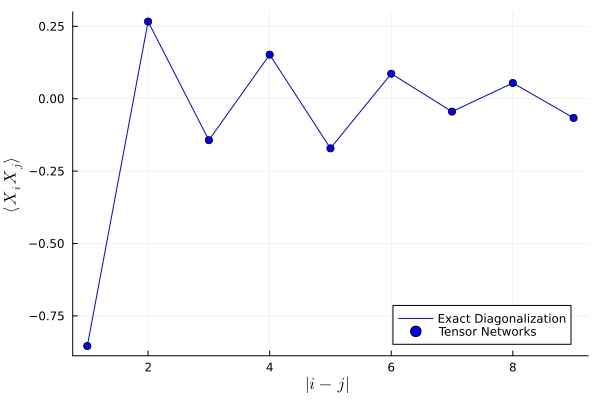

In [118]:
plot(Distance_ij_ED, real(Correlations_ED), label = "Exact Diagonalization", color = "blue")
scatter!(Distance_ij_TN, real(Correlations_TN), label = "Tensor Networks", color = "blue")
xlabel!(L"|i - j|")
ylabel!(L"\langle X_{i}X_{j} \rangle")

In [148]:
site_for_comparison = 5

t = 5
dt = 0.01

0.01

In [149]:
ψt_ED = zero
for i = 1:N-1
    i%2 == 0 ? ψt_ED = kron(ψt_ED, zero) : ψt_ED = kron(ψt_ED, one)
end
# ψt_ED == kron(zero, one, zero, one, zero, one, zero, one, zero, one)

Correlations_Dict_time_ED = Dict()
Correlations_ED, Distance_ij_ED = CorrelationsXiXj_FromCenter_Exact(N, ψt_ED)
Correlations_Dict_time_ED[0.0] = Correlations_ED
@show Correlations_ED[site_for_comparison]

U_ED = Time_Evolution_Op_Exact(dt, H_ED)

@time begin
for t = dt:dt:t
    ψt_ED = U_ED*ψt_ED
    Correlations_ED, Distance_ij_ED = CorrelationsXiXj_FromCenter_Exact(N, ψt_ED)
    Correlations_Dict_time_ED[t] = real(Correlations_ED)    
    @show Correlations_ED[site_for_comparison]
end
end

Correlations_ED[site_for_comparison] = 0.0
Correlations_ED[site_for_comparison] = -1.1606541360728747e-5 + 0.0im
Correlations_ED[site_for_comparison] = -4.639728138751623e-5 + 0.0im
Correlations_ED[site_for_comparison] = -0.00010428559035860012 + 0.0im
Correlations_ED[site_for_comparison] = -0.00018512716048644783 + 0.0im
Correlations_ED[site_for_comparison] = -0.00028872011947357205 + 0.0im
Correlations_ED[site_for_comparison] = -0.00041480519134598655 + 0.0im
Correlations_ED[site_for_comparison] = -0.0005630659063961039 + 0.0im
Correlations_ED[site_for_comparison] = -0.0007331288625569007 + 0.0im
Correlations_ED[site_for_comparison] = -0.0009245640409944615 + 0.0im
Correlations_ED[site_for_comparison] = -0.0011368851791415955 + 0.0im
Correlations_ED[site_for_comparison] = -0.0013695502047961 + 0.0im
Correlations_ED[site_for_comparison] = -0.0016219617352688828 + 0.0im
Correlations_ED[site_for_comparison] = -0.0018934676458852758 + 0.0im
Correlations_ED[site_for_comparison] = -0.00218

In [150]:
Ψt_MPS_TDVP = MPS(sites, [(i%2) + 1 for i=0:N-1]) #Initial MPS

Correlations_Dict_time_TDVP = Dict()
Correlations_TDVP, Distance_ij_TDVP = CorrelationsXiXj_FromCenter_TensorNetworks(Ψt_MPS_TDVP)
Correlations_Dict_time_TDVP[0.0] = Correlations_TDVP
@show Correlations_TDVP[site_for_comparison]

@time begin
for t = dt:dt:t
    Ψt_MPS_TDVP .= tdvp(H_MPO, -im * dt, Ψt_MPS_TDVP; time_step = -im * dt, cutoff = 10e-15, maxdim = 40, normalize = true)
    # normalize!(Ψt_MPS_TDVP)
    Correlations_TDVP, Distance_ij_TDVP = CorrelationsXiXj_FromCenter_TensorNetworks(Ψt_MPS_TDVP)
    Correlations_Dict_time_TDVP[t] = real(Correlations_TDVP) 
    @show Correlations_TDVP[site_for_comparison]
end
end

Correlations_TDVP[site_for_comparison] = 0.0
Correlations_TDVP[site_for_comparison] = -4.42759891001704e-6 - 3.66222311623862e-16im
Correlations_TDVP[site_for_comparison] = -3.368689670823152e-5 - 1.3176169213026118e-17im
Correlations_TDVP[site_for_comparison] = -8.604925896900661e-5 - 3.2865122106761324e-18im
Correlations_TDVP[site_for_comparison] = -0.0001613862652353277 + 6.585682671353274e-18im
Correlations_TDVP[site_for_comparison] = -0.0002595028801380531 + 2.6450929429507698e-18im
Correlations_TDVP[site_for_comparison] = -0.0003801465755915733 + 1.1228629769085891e-18im
Correlations_TDVP[site_for_comparison] = -0.0005230076193785447 - 1.3961100102907326e-17im
Correlations_TDVP[site_for_comparison] = -0.0006877192936576551 - 6.740889384932699e-18im
Correlations_TDVP[site_for_comparison] = -0.0008738582176773044 - 2.82000516045701e-18im
Correlations_TDVP[site_for_comparison] = -0.0010809444821609504 - 2.5176476319733214e-17im
Correlations_TDVP[site_for_comparison] = -0.00130844266

In [151]:
dt_Taylor = -1im*dt
U_MPO = MPO(sites, "Id") + dt_Taylor*H_MPO + (dt_Taylor^2)*apply(H_MPO, H_MPO) + (dt_Taylor^3)*apply(H_MPO, apply(H_MPO, H_MPO)) + (dt_Taylor^4)*apply(H_MPO,apply(H_MPO, apply(H_MPO, H_MPO)))#1 + tH + t^2 H^2 + t^3 H^3

Ψt_MPS_Taylor = MPS(sites, [(i%2) + 1 for i=0:N-1]) #Initial MPS

Correlations_Dict_time_Taylor = Dict()
Correlations_Taylor, Distance_ij_Taylor = CorrelationsXiXj_FromCenter_TensorNetworks(Ψt_MPS_Taylor)
Correlations_Dict_time_Taylor[0.0] = Correlations_Taylor
@show Correlations_Taylor[site_for_comparison]

@time begin
for t = dt:dt:t
    Ψt_MPS_Taylor = apply(U_MPO, Ψt_MPS_Taylor; cutoff = 10e-15, maxdim = 40)
    normalize!(Ψt_MPS_Taylor)
    Correlations_Taylor, Distance_ij_Taylor = CorrelationsXiXj_FromCenter_TensorNetworks(Ψt_MPS_Taylor)
    Correlations_Dict_time_Taylor[t] = real(Correlations_Taylor)    
    @show Correlations_Taylor[site_for_comparison]
end
end

Correlations_Taylor[site_for_comparison] = 0.0
Correlations_Taylor[site_for_comparison] = -2.3161568666912957e-5 + 1.0167909575210763e-16im
Correlations_Taylor[site_for_comparison] = -6.941924525866487e-5 + 5.3834094420529915e-17im
Correlations_Taylor[site_for_comparison] = -0.00013862786706108097 + 3.7159364772458236e-17im
Correlations_Taylor[site_for_comparison] = -0.0002306142189513019 + 2.705284078240235e-17im
Correlations_Taylor[site_for_comparison] = -0.0003451394062104226 + 8.87609630850185e-17im
Correlations_Taylor[site_for_comparison] = -0.0004819054294434497 - 3.780323816711337e-18im
Correlations_Taylor[site_for_comparison] = -0.0006405614498484955 - 8.784519114403465e-17im
Correlations_Taylor[site_for_comparison] = -0.0008206991984323332 - 2.1437783138258983e-16im
Correlations_Taylor[site_for_comparison] = -0.0010218548275467566 - 1.109387988180535e-18im
Correlations_Taylor[site_for_comparison] = -0.0012435094276224668 + 1.2837151133304785e-16im
Correlations_Taylor[site_for_

Now for TEBD we need to do SWAPS, there are many different ways to do it:

In [152]:
# function ITensors.op(::OpName"SWAP", ::SiteType"Qubit", s1::Index, s2::Index)
#   mat = [1 0 0 0
#          0 0 1 0
#          0 1 0 0
#          0 0 0 1]
#   return itensor(mat, s2', s1', s2, s1)
# end
# os = [("SWAP", 1, 2)]
# SWAP = ops(os, sites)

# Ψt_MPS = MPS(sites, [(i%2) + 1 for i=0:N-1]) #Initial MPS
# @show Polarization = [inner(Ψt_MPS , apply(op("Z", s), Ψt_MPS)) for s = sites]; #It is important to check that I put the right numbers
# @show maxlinkdim(Ψt_MPS)

# @time Ψt_MPS = apply(SWAP, Ψt_MPS; maxdim = maxlinkdim(Ψt_MPS))
# @show Polarization = [inner(Ψt_MPS , apply(op("Z", s), Ψt_MPS)) for s = sites]; #It is important to check that I put the right numbers
# @show maxlinkdim(Ψt_MPS)

# #Another way (this is my favorite)
# SWAP = [1 0 0 0; 0 0 1 0; 0 1 0 0; 0 0 0 1] #Two-site SWAP gate

# s1, s2 = sites[1:2] 
# SWAP_op = op(SWAP, [s1,s2])
# @time Ψt_MPS = apply(SWAP_op , Ψt_MPS; maxdim = maxlinkdim(Ψt_MPS))
# @show Polarization = [inner(Ψt_MPS , apply(op("Z", s), Ψt_MPS)) for s = sites]; #It is important to check that I put the right numbers
# @show maxlinkdim(Ψt_MPS)

In [153]:
function TEBD_Build_Gates(dt, sites, J, α)

    N = length(sites)

    SWAP = [1 0 0 0; 0 0 1 0; 0 1 0 0; 0 0 0 1] #Two-site SWAP gate
    
    TEBD_Gates = ITensor[] 
    
    for j = 1:N-1
        distance_ij = 1
        for i = 1:N-1
            # i <= N-j ? println(distance_ij) : nothing
            
            s1, s2 = sites[i:i+1] 
            H_gate = J*exp(-α*distance_ij)*(op("X",s1)*op("X",s2) + op("Y",s1)*op("Y",s2))
            U_Gate = exp(-0.5im*dt*H_gate)
            if i <= N-j 
                push!(TEBD_Gates, U_Gate) 
                distance_ij = distance_ij + 1 
            end
            SWAP_op = op(SWAP, [s1,s2])
            push!(TEBD_Gates, SWAP_op)
        end
    end

    append!(TEBD_Gates, reverse(TEBD_Gates))

    return TEBD_Gates
end

TEBD_Build_Gates (generic function with 1 method)

In [154]:
TEBD_Gates = TEBD_Build_Gates(dt, sites, J, α);

In [155]:
Ψt_MPS_TEBD = MPS(sites, [(i%2) + 1 for i=0:N-1]) #Initial MPS

Correlations_Dict_time_TEBD = Dict()
Correlations_TEBD, Distance_ij_TEBD = CorrelationsXiXj_FromCenter_TensorNetworks(Ψt_MPS_TEBD)
Correlations_Dict_time_TEBD[0.0] = Correlations_TEBD
@show Correlations_TEBD[site_for_comparison]

@time begin
for t = dt:dt:t
    Ψt_MPS_TEBD = apply(TEBD_Gates, Ψt_MPS_TEBD; cutoff = 10e-15, maxdim = 40)
    normalize!(Ψt_MPS_TEBD)
    Correlations_TEBD, Distance_ij_TEBD = CorrelationsXiXj_FromCenter_TensorNetworks(Ψt_MPS_TEBD)
    Correlations_Dict_time_TEBD[t] = real(Correlations_TEBD)  
    @show Correlations_TEBD[site_for_comparison]
end
end

Correlations_TEBD[site_for_comparison] = 0.0
Correlations_TEBD[site_for_comparison] = -1.1597348331964836e-5 - 5.56568532556096e-18im
Correlations_TEBD[site_for_comparison] = -4.6390803033862884e-5 + 2.1806960047887523e-17im
Correlations_TEBD[site_for_comparison] = -0.00010429336039546342 + 1.3155407902477808e-18im
Correlations_TEBD[site_for_comparison] = -0.0001851496372708357 - 1.4959912352632183e-17im
Correlations_TEBD[site_for_comparison] = -0.00028874376887294946 + 6.255969322675691e-18im
Correlations_TEBD[site_for_comparison] = -0.0004148340056602302 + 2.28454966361596e-17im
Correlations_TEBD[site_for_comparison] = -0.0005630863425300362 - 2.155322625534089e-19im
Correlations_TEBD[site_for_comparison] = -0.00073317278579759 - 2.907545428772387e-17im
Correlations_TEBD[site_for_comparison] = -0.0009246023950760469 - 4.429213199989156e-18im
Correlations_TEBD[site_for_comparison] = -0.0011369305032081314 - 1.2637264881932882e-19im
Correlations_TEBD[site_for_comparison] = -0.001369601

For W1:

In [156]:
function get_U_W1(sites, J, α, dt)
    # Create object for MPO with bond dimensions
    N = length(sites);
    U_W1 = MPO(N);
    bondindex = [Index(3, "Link,l="*string(n)) for n in 1:N-1];

    # Left core
    n = 1;
    core = ITensor(ComplexF64, sites[n], sites[n]', bondindex[n]);
    # core[1] = I
    core[sites[n]=>1, sites[n]'=>1, bondindex[n]=>1] = 1.0;
    core[sites[n]=>2, sites[n]'=>2, bondindex[n]=>1] = 1.0;
    # core[2] = √dt exp(-α) X
    core[sites[n]=>1, sites[n]'=>2, bondindex[n]=>2] = √(dt)*exp(-α);
    core[sites[n]=>2, sites[n]'=>1, bondindex[n]=>2] = √(dt)*exp(-α);
    # core[3] = √dt exp(-α) Y
    core[sites[n]=>1, sites[n]'=>2, bondindex[n]=>3] = -1im*√(dt)*exp(-α);
    core[sites[n]=>2, sites[n]'=>1, bondindex[n]=>3] = 1im*√(dt)*exp(-α);
    U_W1[n] = core;

    # Center cores
    for n in 2:N-1
        core = ITensor(ComplexF64, bondindex[n-1], sites[n], sites[n]', bondindex[n]);
        # core[1,1] = I
        core[bondindex[n-1]=>1, sites[n]=>1, sites[n]'=>1, bondindex[n]=>1] = 1.0;
        core[bondindex[n-1]=>1, sites[n]=>2, sites[n]'=>2, bondindex[n]=>1] = 1.0;
        # core[1,2] = √dt exp(-α) X
        core[bondindex[n-1]=>1, sites[n]=>1, sites[n]'=>2, bondindex[n]=>2] = √(dt)*exp(-α);
        core[bondindex[n-1]=>1, sites[n]=>2, sites[n]'=>1, bondindex[n]=>2] = √(dt)*exp(-α);
        # core[1,3] = √dt exp(-α) Y
        core[bondindex[n-1]=>1, sites[n]=>1, sites[n]'=>2, bondindex[n]=>3] = -1im*√(dt)*exp(-α);
        core[bondindex[n-1]=>1, sites[n]=>2, sites[n]'=>1, bondindex[n]=>3] = 1im*√(dt)*exp(-α);
        # core[2,1] = √dt J X
        core[bondindex[n-1]=>2, sites[n]=>1, sites[n]'=>2, bondindex[n]=>1] = √(dt)*J;
        core[bondindex[n-1]=>2, sites[n]=>2, sites[n]'=>1, bondindex[n]=>1] = √(dt)*J;
        # core[3,1] = √dt J Y
        core[bondindex[n-1]=>3, sites[n]=>1, sites[n]'=>2, bondindex[n]=>1] = -1im*√(dt)*J;
        core[bondindex[n-1]=>3, sites[n]=>2, sites[n]'=>1, bondindex[n]=>1] = 1im*√(dt)*J;
        # core[2,2] = exp(-α) I
        core[bondindex[n-1]=>2, sites[n]=>1, sites[n]'=>1, bondindex[n]=>2] = exp(-α);
        core[bondindex[n-1]=>2, sites[n]=>2, sites[n]'=>2, bondindex[n]=>2] = exp(-α);
        # core[3,3] = exp(-α) I
        core[bondindex[n-1]=>3, sites[n]=>1, sites[n]'=>1, bondindex[n]=>3] = exp(-α);
        core[bondindex[n-1]=>3, sites[n]=>2, sites[n]'=>2, bondindex[n]=>3] = exp(-α);
        U_W1[n] = core;
    end;

    # Right core
    n = N;
    core = ITensor(ComplexF64, bondindex[n-1], sites[n], sites[n]');
    # core[1,1] = I
    core[bondindex[n-1]=>1, sites[n]=>1, sites[n]'=>1] = 1.0;
    core[bondindex[n-1]=>1, sites[n]=>2, sites[n]'=>2] = 1.0;
    # core[2,1] = √dt J X
    core[bondindex[n-1]=>2, sites[n]=>1, sites[n]'=>2] = √(dt)*J;
    core[bondindex[n-1]=>2, sites[n]=>2, sites[n]'=>1] = √(dt)*J;
    # core[3,1] = √dt J Y
    core[bondindex[n-1]=>3, sites[n]=>1, sites[n]'=>2] = -1im*√(dt)*J;
    core[bondindex[n-1]=>3, sites[n]=>2, sites[n]'=>1] = 1im*√(dt)*J;
    U_W1[n] = core;

    return U_W1;
end;

In [157]:
dt_W1 = -1im*dt;
U_MPO = get_U_W1(sites, J, α, dt_W1);

Ψt_MPS_W1 = MPS(sites, [(i%2) + 1 for i=0:N-1]) #Initial MPS

Correlations_Dict_time_W1 = Dict()
Correlations_W1, Distance_ij_W1 = CorrelationsXiXj_FromCenter_TensorNetworks(Ψt_MPS_W1)
Correlations_Dict_time_W1[0.0] = Correlations_W1
@show Correlations_W1[site_for_comparison]

@time begin
for t = dt:dt:t
    Ψt_MPS_W1 = apply(U_MPO, Ψt_MPS_W1; cutoff = 10e-15, maxdim = 40)
    normalize!(Ψt_MPS_W1)
    Correlations_W1, Distance_ij_W1 = CorrelationsXiXj_FromCenter_TensorNetworks(Ψt_MPS_W1)
    Correlations_Dict_time_W1[t] = real(Correlations_W1)    
    @show Correlations_W1[site_for_comparison]
end
end

Correlations_W1[site_for_comparison] = 0.0
Correlations_W1[site_for_comparison] = 6.364469789250194e-17 + 9.302233815997961e-17im
Correlations_W1[site_for_comparison] = -2.3201445450736485e-5 - 7.3848347980388e-18im
Correlations_W1[site_for_comparison] = -6.955644719514164e-5 + 8.394318221632752e-18im
Correlations_W1[site_for_comparison] = -0.00013895866172918204 + 3.984303183695822e-18im
Correlations_W1[site_for_comparison] = -0.00023124490647473883 + 1.3497042910071014e-17im
Correlations_W1[site_for_comparison] = -0.00034619403796954144 + 4.157705719110171e-19im
Correlations_W1[site_for_comparison] = -0.0004835195849102556 + 4.129985365817642e-18im
Correlations_W1[site_for_comparison] = -0.0006428881367989137 + 7.121717211739326e-18im
Correlations_W1[site_for_comparison] = -0.0008239043349444607 - 3.626611890471269e-18im
Correlations_W1[site_for_comparison] = -0.0010261155029092344 + 4.839596096064445e-18im
Correlations_W1[site_for_comparison] = -0.001249011897021458 - 3.553176556580

Let's compare all methods

In [158]:
function get_cor_dist_t_fromDict(Dict, dist, times)

    array = []
    for t = times
        append!(array, Dict[t][dist])
    end

    return array
end    

get_cor_dist_t_fromDict (generic function with 1 method)

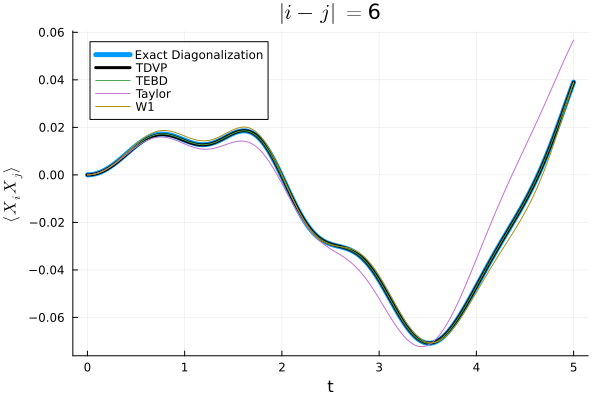

In [159]:
dist_for_comparison =  6
times =  0.0:dt:t

plot(times, get_cor_dist_t_fromDict(Correlations_Dict_time_ED, dist_for_comparison, times), label = "Exact Diagonalization", linewidth = 5.0)
plot!(times, get_cor_dist_t_fromDict(Correlations_Dict_time_TDVP, dist_for_comparison, times), label = "TDVP", linewidth = 3.0, color = "black")
plot!(times, get_cor_dist_t_fromDict(Correlations_Dict_time_TEBD, dist_for_comparison, times), label = "TEBD", linewidth = 1.0)
plot!(times, get_cor_dist_t_fromDict(Correlations_Dict_time_Taylor, dist_for_comparison, times), label = "Taylor", linewidth = 1.0)
plot!(times, get_cor_dist_t_fromDict(Correlations_Dict_time_W1, dist_for_comparison, times), label = "W1", linewidth = 1.0)

xlabel!("t")
ylabel!(L"\langle X_{i} X_{j} \rangle")
title!(L"| i - j | = "*"$dist_for_comparison")

**Pendiente:**

- Implementar W1 (importante jaja) 
- Comparar tiempos y ver cual está más cerca del caso exacto
- Comparar para cadenas más largas y correlaciones más lejanas
- GPU?